# Tentativa de previsão utilizando variáveis além do PLD

- Bases de dados




## Bases

Os dados foram retirados de duas fontes, ONS e CCEE. Dados provenientes da ONS estão distribuídos em duas fontes diferentes, uma com arquivos no formato `.csv` e outra com os dados apresentados utilizando Tableau, necessitando de alguns passos manuais para sua extração.

A maior parte dos dados estava em base horária, com exceção do PLD, que estava em base horária. Para ter uma análise com os dados em uma mesma base, os valores de PLD foram agrupados por média diária.

Após este tratamento, todos os dados coletados foram reunidos em um único arquivo.


#### Fontes:

- CCEE: https://www.ccee.org.br/web/guest/precos/painel-precos
- ONS (Tableau): http://www.ons.org.br/Paginas/resultados-da-operacao/historico-da-operacao/
- ONS (csv): https://dados.ons.org.br/


#### Variáveis
- data: dia da observação
- submercado: região da observação - Norte, Nordeste, Sudeste (abrange também o Centro-Oeste) e Sul
- pld_medio: valor médio de todos os plds horários no dia da observação 
- ear_max: energia armazenada máxima
- ear_verif_mwmes: energia armazenada verificada (MWMes)
- ear_verif_percentual: energia armazenada percentual (ear_verif_mwmes/ear_max)
- ena_bruta_mwmed: energia natural afluente bruta (MWMes)
- ena_bruta_percentual: energia natural afluente bruta percentual
- ena_armazenavel_mwmed: energia natural afluente armazenavel (MWmed)
- ena_armazenavel_percentual: energia natural afluente armazenavel percentual
- demanda_mwh: demanda máxima diária por subsistema
- geracao_mwh: Energia gerada a partir de qualquer fonte de recurso
- carga_mwmed
- cmo_blr_mwh: Custo Marginal de Operação em R$/MWh. Representa o custo de se adicionar 1 MWh no sistema


#### ENA DIÁRIO POR SUBSISTEMA (ENA MÁXIMA, ENA NO DIA EM MWMÊS, ENA NO DIA EM %)
 
Dados de Energia Natural Afluente (ENA) em periodicidade diária por Subsistema.

A ENA Bruta representa a energia produzível pelo reservatório e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Mais sobre o ENA: https://esferaenergia.com.br/blog/energia-natural-afluente/


#### EAR DIÁRIO POR SUBSISTEMA (EAR MÁXIMA, EAR NO DIA EM MWMÊS, EAR NO DIA EM %)

Dados de Energia Armazenada (EAR) em periodicidade diária por Subsistema. Esta grandeza representa a energia associada ao volume de  água armazenado nos reservatórios que pode  ser convertido  em  geração  na  própria  usina  e  em  todas  as  usinas  a  jusante  da  cascata.  A grandeza de EAR considera o nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima é a capacidade de armazenamento caso todos os reservatórios estivessem cheios.


Mais sobre o EAR: https://megawhat.energy/verbetes/311/energia-armazenada


#### Carga de energia

Carga equivalente à integral das cargas de demanda em um determinado período de tempo, expressa em MWh. Quando expressa em MW-médio, em uma determinada base de tempo, como, por exemplo, MW-médio em base anual, refere-se a uma unidade de energia convencionada, expressa pelo valor médio da potência ativa que, multiplicada pelo intervalo de tempo considerado, define a energia ativa consumida nesse mesmo intervalo.

http://www.ons.org.br/paginas/conhecimento/glossario


#### CMO - Custo Marginal de Operação

Resumidamente, representa o custo de se adicionar uma unidade de megawhatt no sistema elétrico. Essa variável é fornecida pela ONS em base [semi-horária](http://www.ons.org.br/paginas/energia-amanha/cmo-semi-horario/cmo-semi-hor%C3%A1rio) e [semanal](http://www.ons.org.br/Paginas/resultados-da-operacao/historico-da-operacao/cmo.aspx).

A CCEE aponta o CMO como sendo a variável base para os modelos que calculam o PLD (https://www.ccee.org.br/precos/conceitos-precos).



## Análise exploratória

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('../data/raw/dados.csv')

In [3]:
data.head()

,data,subsistema,pld_medio,ear_max,ear_verif_mwmes,ear_verif_percentual,ena_bruta_mwmed,ena_bruta_percentual,ena_armazenavel_mwmed,ena_armazenavel_percentual,carga_mwmed,demanda_mwh,geracao_gwh,cmo_blr_mwh
0,2018-04-17,NORDESTE,112.59,51602.070312,20333.150391,39.403702,4618.331055,39.798599,4473.817871,38.553299,10505.047250,11385.581,181.195640,117.14
1,2018-04-18,NORDESTE,94.14,51602.070312,20386.072266,39.506302,4395.471191,37.878101,4267.705078,36.777100,10383.894042,11389.195,196.178482,113.16
2,2018-04-19,NORDESTE,92.50,51602.070312,20439.525391,39.609901,4281.795898,36.898499,4161.067871,35.858200,10620.182625,11794.672,193.670291,90.74
3,2018-04-20,NORDESTE,118.00,51602.070312,20483.466797,39.695000,4208.751953,36.269100,4099.557129,35.328098,10643.009583,11593.281,173.938131,120.83
4,2018-04-21,NORDESTE,40.16,51602.070312,20545.970703,39.816200,4212.644043,36.302601,4093.782959,35.278301,9625.620083,11083.048,176.734106,101.86


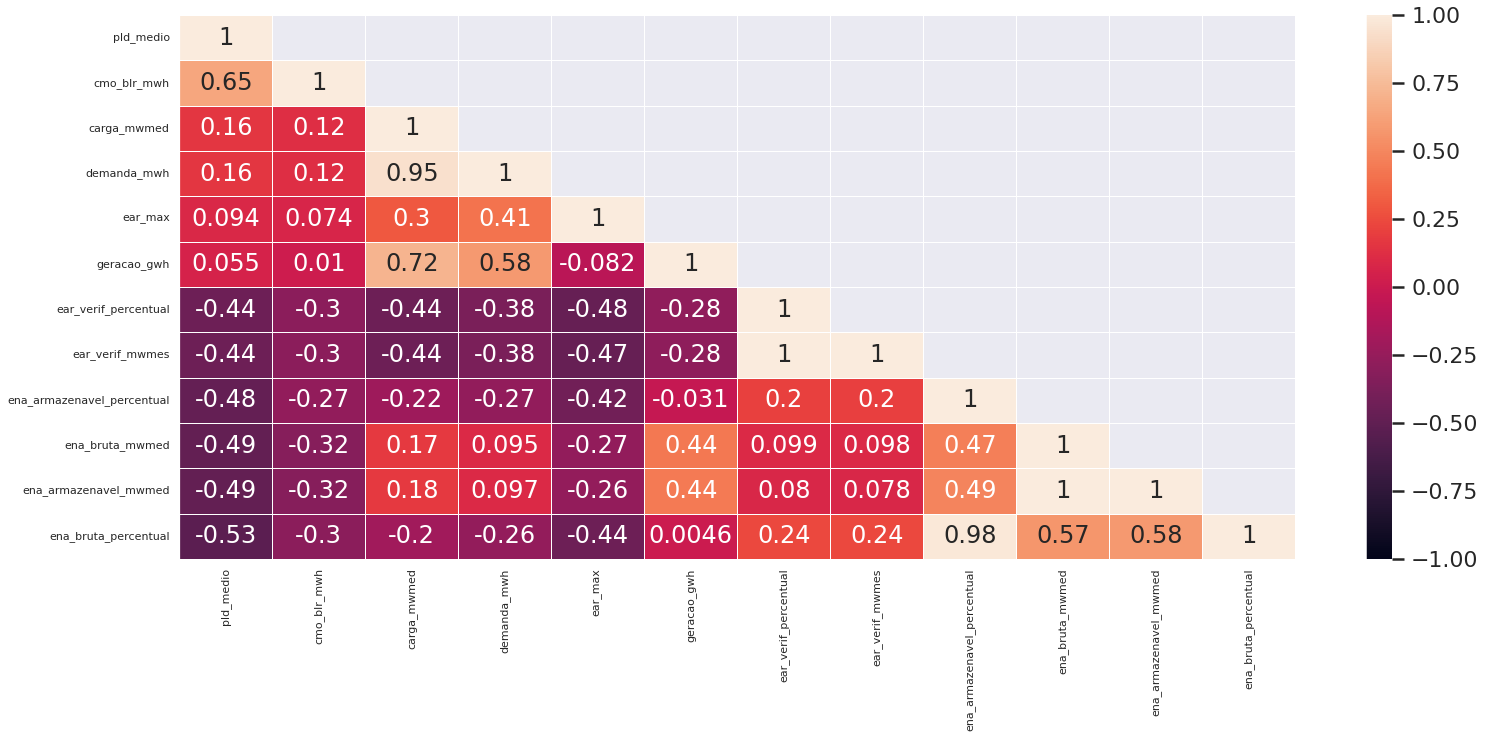

In [4]:
correlations_data = data.query('subsistema == "SUDESTE"').corr('spearman')
# correlations_data = data.query('subsistema == "NORDESTE"').corr()
# correlations_data = data.corr()
correlations_data = correlations_data.sort_values('pld_medio', ascending=False)
correlations_data = correlations_data[list(correlations_data.index)]


# plotando
f, ax = plt.subplots(figsize=(25,10))
plt.style.use('seaborn-notebook')
sns.set_context('poster',font_scale=1)
sns.set_color_codes("pastel")

matrix = np.triu(correlations_data, k=1)

ax = sns.heatmap(correlations_data, annot=True, linewidths=1, vmin=-1, vmax=1, mask=matrix)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

sns.despine(left=False, bottom=True)

# ax.get_figure().savefig("output.png", bbox_inches='tight')



In [5]:
correlations_data = correlations_data[list(correlations_data.index)]

In [6]:
correlations_data

,pld_medio,cmo_blr_mwh,carga_mwmed,demanda_mwh,ear_max,geracao_gwh,ear_verif_percentual,ear_verif_mwmes,ena_armazenavel_percentual,ena_bruta_mwmed,ena_armazenavel_mwmed,ena_bruta_percentual
pld_medio,1.000000,0.645802,0.163851,0.162671,0.093599,0.055143,-0.441987,-0.442418,-0.480028,-0.490913,-0.490936,-0.529182
cmo_blr_mwh,0.645802,1.000000,0.124470,0.124004,0.074214,0.010184,-0.301228,-0.301496,-0.269858,-0.323045,-0.322670,-0.303484
carga_mwmed,0.163851,0.124470,1.000000,0.945087,0.302481,0.716170,-0.443306,-0.442804,-0.217058,0.173834,0.178164,-0.198131
demanda_mwh,0.162671,0.124004,0.945087,1.000000,0.406450,0.584429,-0.376430,-0.375169,-0.271209,0.094537,0.097492,-0.260334
ear_max,0.093599,0.074214,0.302481,0.406450,1.000000,-0.082317,-0.475640,-0.471265,-0.419566,-0.268250,-0.264327,-0.440801
geracao_gwh,0.055143,0.010184,0.716170,0.584429,-0.082317,1.000000,-0.280646,-0.281869,-0.030957,0.435028,0.439670,0.004576
ear_verif_percentual,-0.441987,-0.301228,-0.443306,-0.376430,-0.475640,-0.280646,1.000000,0.999979,0.203144,0.099172,0.079560,0.238784
ear_verif_mwmes,-0.442418,-0.301496,-0.442804,-0.375169,-0.471265,-0.281869,0.999979,1.000000,0.201228,0.097851,0.078222,0.236792
ena_armazenavel_percentual,-0.480028,-0.269858,-0.217058,-0.271209,-0.419566,-0.030957,0.203144,0.201228,1.000000,0.465091,0.490382,0.979846
ena_bruta_mwmed,-0.490913,-0.323045,0.173834,0.094537,-0.268250,0.435028,0.099172,0.097851,0.465091,1.000000,0.997240,0.566271


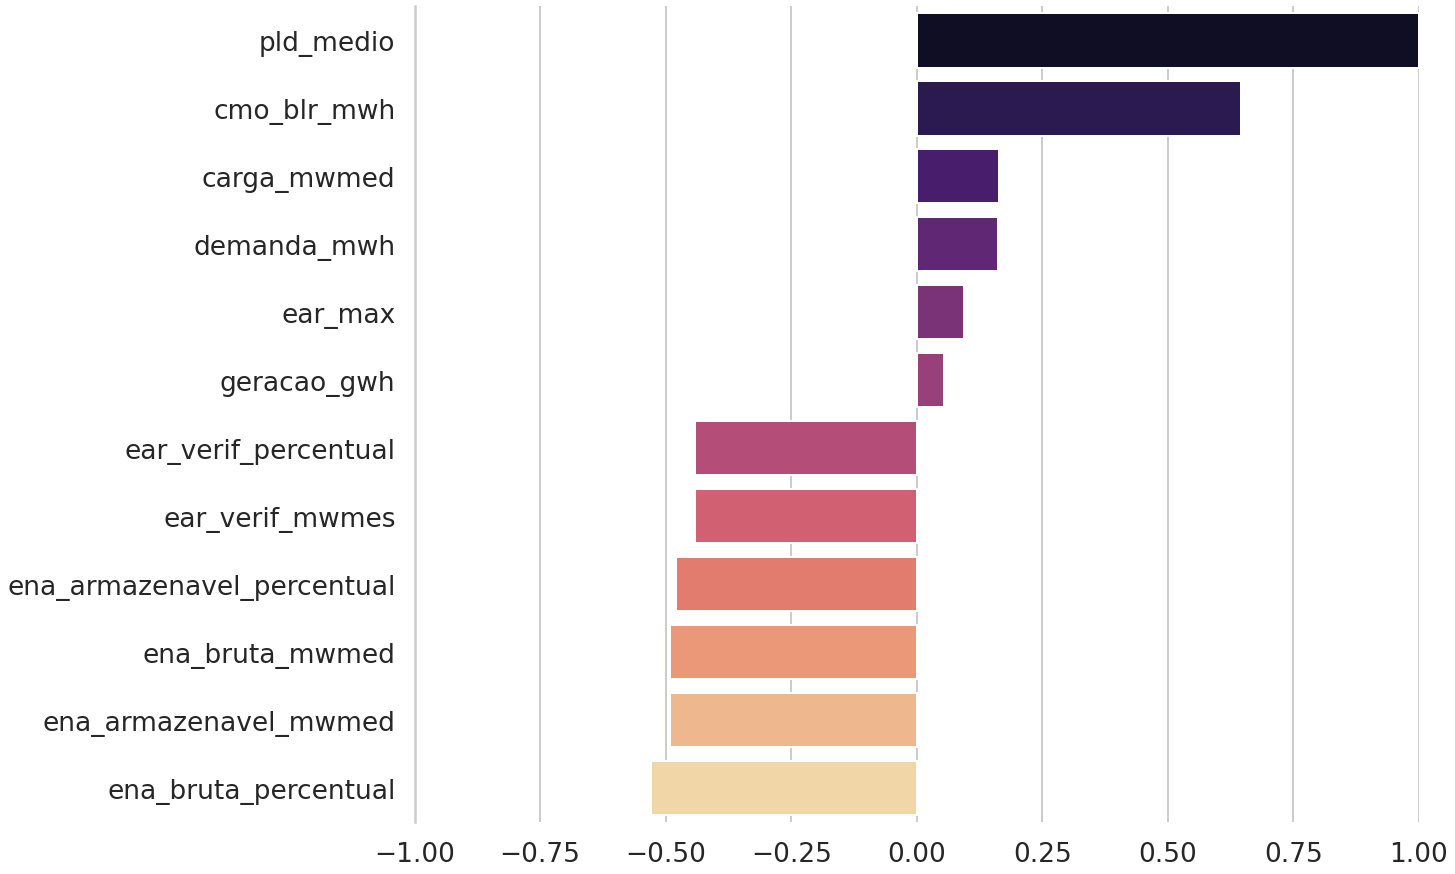

In [7]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 15))
corr_pld = correlations_data['pld_medio'].sort_values(ascending=False)
sns.barplot(x=corr_pld.values, y=corr_pld.keys(), palette='magma')
axes.set(ylabel="", xlabel="", xlim=(-1, 1))
sns.despine(left=False, bottom=True)

fig.get_figure().savefig("output.png", bbox_inches='tight')



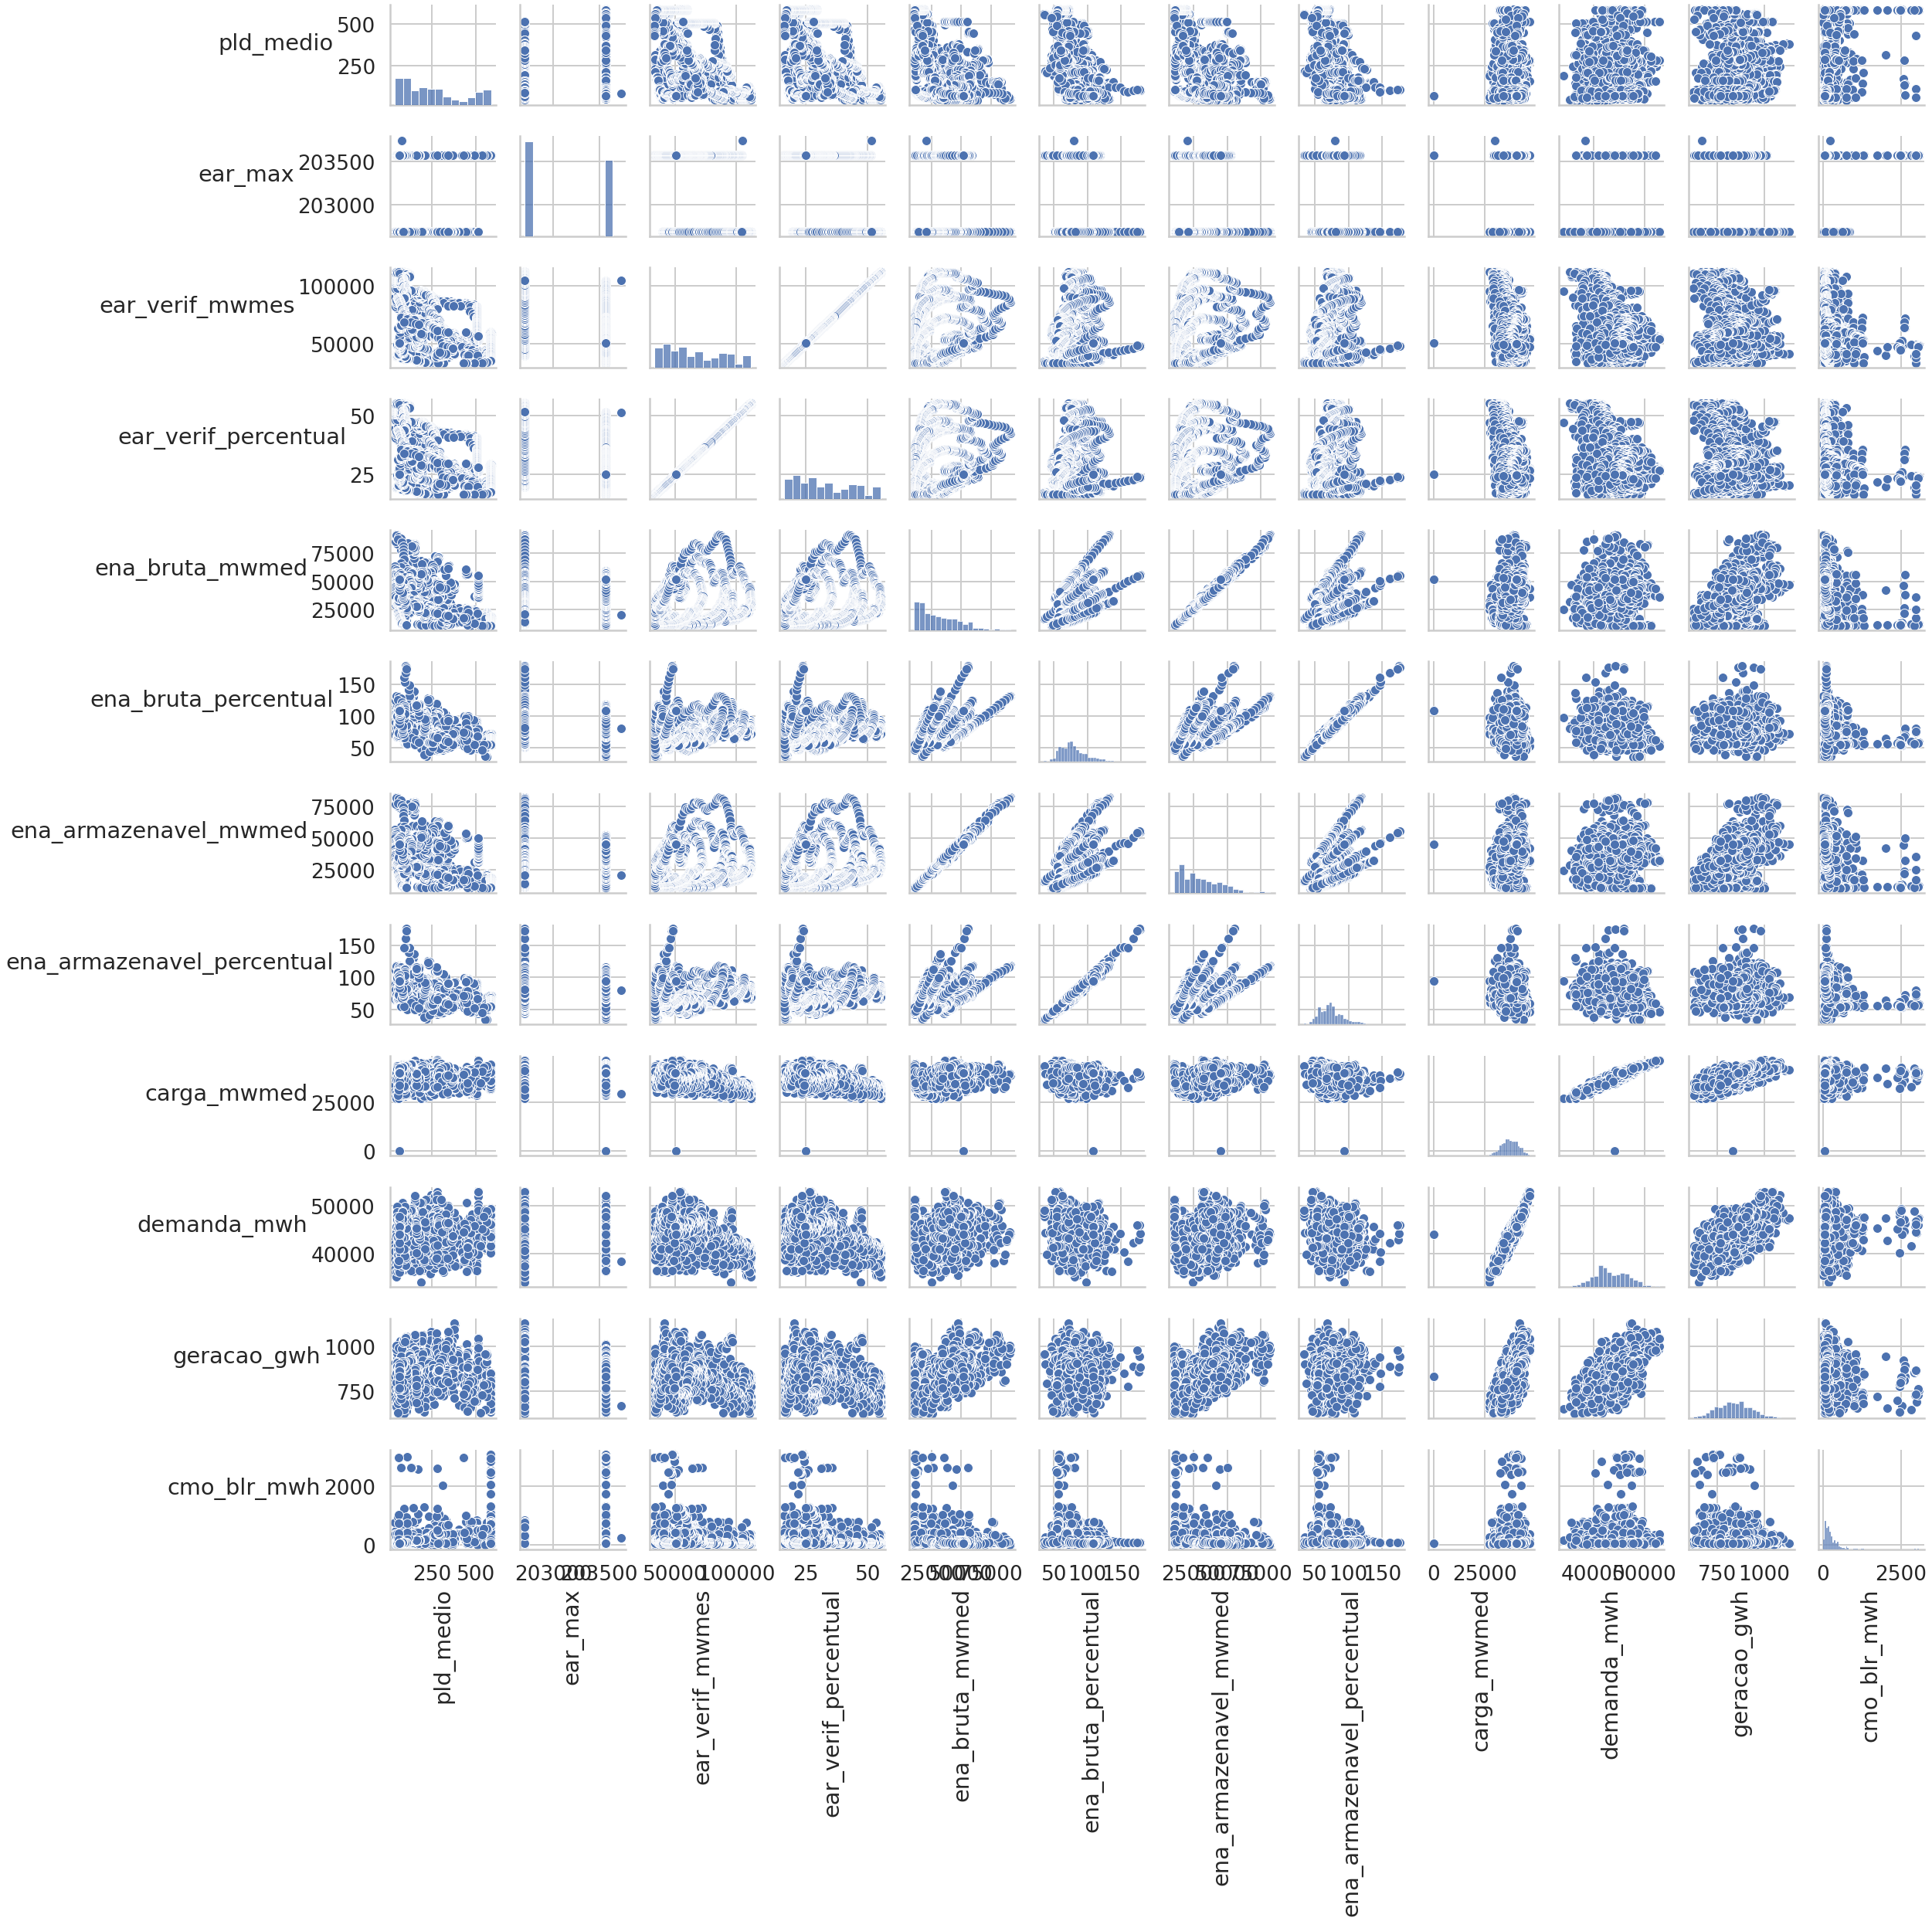

In [8]:
def plot_pairs(data):
    g = sns.pairplot(data)
    for ax in g.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = 90)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = 0)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')

plot_pairs(data.query('subsistema == "SUDESTE"'))
        

In [9]:
def get_high_correlated_pairs(data, threshold, method='spearman'):
    # threshold=0.9
    # method='spearman'
    corr_matrix = data.corr(method)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    x = upper.reset_index().melt(id_vars=['index'])
    return x[(x['index'] != x['variable']) & (x['value'] > 0.9)]


In [10]:
sudeste = data.query('subsistema == "SUDESTE"')
get_high_correlated_pairs(sudeste, threshold=0.6)


,index,variable,value
38,ear_verif_mwmes,ear_verif_percentual,0.999979
76,ena_bruta_mwmed,ena_armazenavel_mwmed,0.997240
89,ena_bruta_percentual,ena_armazenavel_percentual,0.979846
116,carga_mwmed,demanda_mwh,0.945087


In [11]:
to_drop = ['ear_verif_mwmes', 'ena_armazenavel_mwmed', 'ena_armazenavel_percentual', 'demanda_mwh']
_sudeste = sudeste.drop(columns=to_drop)
_sudeste = _sudeste.drop(columns=['subsistema']).set_index('data')

In [12]:
_sudeste.head()

,pld_medio,ear_max,ear_verif_percentual,ena_bruta_mwmed,ena_bruta_percentual,carga_mwmed,geracao_gwh,cmo_blr_mwh
data,,,,,,,,
2018-04-17,91.80,202691.9375,44.259899,47783.187500,88.299103,36210.712042,859.200574,80.01
2018-04-18,94.12,202691.9375,44.369099,47019.753906,86.888298,36061.056792,857.248762,86.25
2018-04-19,95.16,202691.9375,44.438400,46469.687500,85.871902,36297.196250,879.321536,83.98
2018-04-20,118.53,202691.9375,44.444000,45532.019531,84.139099,36720.809542,883.798485,122.27
2018-04-21,40.16,202691.9375,44.519199,44560.945312,82.344704,32015.163542,804.052608,9.20


## Divisão treino/teste

O dado é temporal, então a princípio vou dividir em algum ponto do tempo (70/30)

In [13]:
from sklearn.model_selection import train_test_split

train_size = 0.8
n_train = int(len(_sudeste)*train_size)

train = _sudeste.iloc[:n_train]
test = _sudeste.drop(train.index)

X_train, y_train = train.drop(columns=['pld_medio']), train['pld_medio']
X_test, y_test = test.drop(columns=['pld_medio']), test['pld_medio']

# train, y = _sudeste.drop(columns=['pld_medio']), _sudeste['pld_medio']

# X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2)



In [14]:
print(f'{X_train.shape = }\n{X_test.shape = }\n{y_train.shape = }\n{y_test.shape = }\n')

X_train.shape = (1083, 7)
X_test.shape = (271, 7)
y_train.shape = (1083,)
y_test.shape = (271,)



## Definição do pipeline


In [15]:
X_train.head()

,ear_max,ear_verif_percentual,ena_bruta_mwmed,ena_bruta_percentual,carga_mwmed,geracao_gwh,cmo_blr_mwh
data,,,,,,,
2018-04-17,202691.9375,44.259899,47783.187500,88.299103,36210.712042,859.200574,80.01
2018-04-18,202691.9375,44.369099,47019.753906,86.888298,36061.056792,857.248762,86.25
2018-04-19,202691.9375,44.438400,46469.687500,85.871902,36297.196250,879.321536,83.98
2018-04-20,202691.9375,44.444000,45532.019531,84.139099,36720.809542,883.798485,122.27
2018-04-21,202691.9375,44.519199,44560.945312,82.344704,32015.163542,804.052608,9.20


In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Regressão Linear
from sklearn.linear_model import LinearRegression
# KNR
from sklearn.neighbors import KNeighborsRegressor
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gadient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# svr
from sklearn.svm import SVR
# Rede Neural
from sklearn.neural_network import MLPRegressor



In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
treino = scaler.fit_transform(X_train, y=y_train)
teste = scaler.transform(X_test)

In [18]:
treino

array([[0.        , 0.71872797, 0.45985769, ..., 0.46845508, 0.46579811,
        0.03040887],
       [0.        , 0.72155393, 0.45035609, ..., 0.46087159, 0.46198451,
        0.03278047],
       [0.        , 0.72334737, 0.44351003, ..., 0.4728375 , 0.50511195,
        0.03191772],
       ...,
       [0.83791871, 0.48727793, 0.36754821, ..., 0.67105125, 0.43515079,
        0.10985732],
       [0.83791871, 0.48985285, 0.35734696, ..., 0.4720829 , 0.24924057,
        0.06238361],
       [0.83791871, 0.49085703, 0.34867476, ..., 0.4850299 , 0.2394415 ,
        0.05579331]])

## Predict

In [19]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape


In [20]:
def executa_e_avalia_modelo(model, treino, y_train, teste, y_test):
    # Treinar o modelo
    model.fit(treino, y_train)

    # Fazendo predições e avaliando
    model_pred = model.predict(teste)

    model_mae = mae(y_test, model_pred)
    model_mse = mse(y_test, model_pred)
    model_mape = mape(y_test, model_pred)

    return model_mae, model_mse, model_mape

In [21]:
resultados = {}

In [22]:
linear = LinearRegression()

model_mae, model_mse, model_mape = executa_e_avalia_modelo(linear, treino, y_train, teste, y_test)

print(f'Modelo: Regressão linear\nResultados: {model_mae = }  {model_mse = }  {model_mape = }')

resultados['Regressão Linear'] = dict(
    mae=model_mae,
    mse=model_mse,
    mape=model_mape,
)



Modelo: Regressão linear
Resultados: model_mae = 126.78451066365236  model_mse = 29927.489363300832  model_mape = 0.7210491446691796


In [23]:
knr = KNeighborsRegressor()

model_mae, model_mse, model_mape = executa_e_avalia_modelo(knr, treino, y_train, teste, y_test)

print(f'Modelo: KNRegressor\nResultados: {model_mae = }  {model_mse = }  {model_mape = }')

resultados['KNeighborsRegressor'] = dict(
    mae=model_mae,
    mse=model_mse,
    mape=model_mape,
)



Modelo: KNRegressor
Resultados: model_mae = 138.04751291512915  model_mse = 26928.321370715865  model_mape = 0.7753285099064621


In [24]:
rf = RandomForestRegressor()

model_mae, model_mse, model_mape = executa_e_avalia_modelo(rf, treino, y_train, teste, y_test)

print(f'Modelo: Random Forest\nResultados: {model_mae = }  {model_mse = }  {model_mape = }')


resultados['RandomForest'] = dict(
    mae=model_mae,
    mse=model_mse,
    mape=model_mape,
)




Modelo: Random Forest
Resultados: model_mae = 154.3100509225092  model_mse = 32496.368088554886  model_mape = 0.8036437989588272


In [25]:
gb = GradientBoostingRegressor()

model_mae, model_mse, model_mape = executa_e_avalia_modelo(gb, treino, y_train, teste, y_test)

print(f'Modelo: Gradient Boosting\nResultados: {model_mae = }  {model_mse = }  {model_mape = }')


resultados['GradientBoostingRegressor'] = dict(
    mae=model_mae,
    mse=model_mse,
    mape=model_mape,
)



Modelo: Gradient Boosting
Resultados: model_mae = 150.22063732983457  model_mse = 34695.76672982782  model_mape = 0.657878427465387


In [26]:
svr = SVR()

model_mae, model_mse, model_mape = executa_e_avalia_modelo(svr, treino, y_train, teste, y_test)

print(f'Modelo: SVR\nResultados: {model_mae = }  {model_mse = }  {model_mape = }')


resultados['SVR'] = dict(
    mae=model_mae,
    mse=model_mse,
    mape=model_mape,
)




Modelo: SVR
Resultados: model_mae = 185.98612435253963  model_mse = 52721.99050237138  model_mape = 0.8037650117302316


In [27]:
mlp = MLPRegressor()

model_mae, model_mse, model_mape = executa_e_avalia_modelo(mlp, treino, y_train, teste, y_test)

print(f'Modelo: MLP\nResultados: {model_mae = }  {model_mse = }  {model_mape = }')


resultados['MLP'] = dict(
    mae=model_mae,
    mse=model_mse,
    mape=model_mape,
)




Modelo: MLP
Resultados: model_mae = 190.699963571641  model_mse = 51401.339130373155  model_mape = 0.9555867518353981


In [28]:
resultados

{'Regressão Linear': {'mae': 126.78451066365236,
  'mse': 29927.489363300832,
  'mape': 0.7210491446691796},
 'KNeighborsRegressor': {'mae': 138.04751291512915,
  'mse': 26928.321370715865,
  'mape': 0.7753285099064621},
 'RandomForest': {'mae': 154.3100509225092,
  'mse': 32496.368088554886,
  'mape': 0.8036437989588272},
 'GradientBoostingRegressor': {'mae': 150.22063732983457,
  'mse': 34695.76672982782,
  'mape': 0.657878427465387},
 'SVR': {'mae': 185.98612435253963,
  'mse': 52721.99050237138,
  'mape': 0.8037650117302316},
 'MLP': {'mae': 190.699963571641,
  'mse': 51401.339130373155,
  'mape': 0.9555867518353981}}

In [29]:
modelos = pd.DataFrame.from_dict(resultados, orient='index').reset_index().rename(columns={'index': 'modelo'})

In [43]:
modelos[['modelo', 'mape']].head()

,modelo,mape
0,Regressão Linear,0.721049
1,KNeighborsRegressor,0.775329
2,RandomForest,0.803644
3,GradientBoostingRegressor,0.657878
4,SVR,0.803765


<AxesSubplot:ylabel='modelo'>

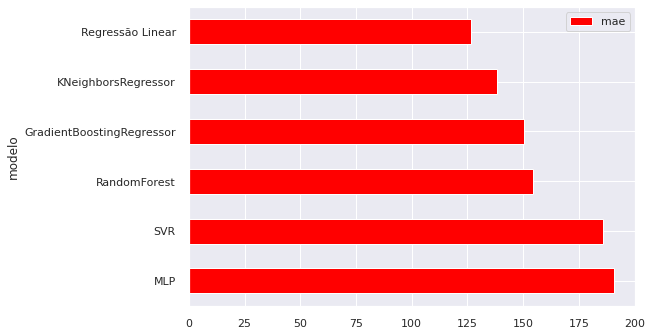

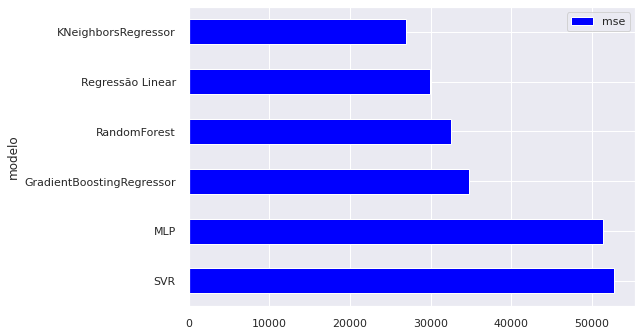

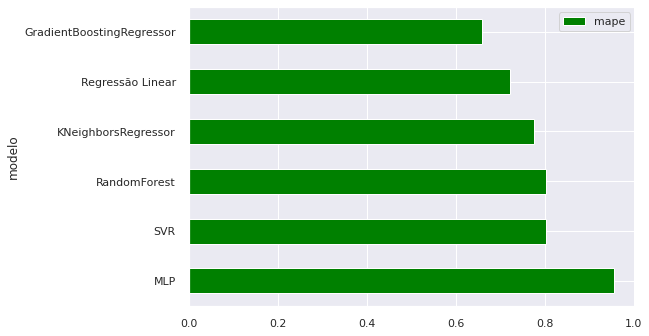

In [42]:
# plots
modelos.sort_values('mae', ascending = False).plot(x='modelo',
                                                   y='mae',
                                                   kind='barh',
                                                   color='red',
                                                   # edgecolor='black',
                                                   )

modelos.sort_values('mse', ascending = False).plot(x='modelo',
                                                   y='mse',
                                                   kind='barh',
                                                   color='blue',
                                                   # edgecolor='black',
                                                   )

modelos.sort_values('mape', ascending = False).plot(x='modelo',
                                                    y='mape',
                                                    kind='barh',
                                                    color='green',
                                                    # edgecolor='black',
                                                    )
# axes
# plt.ylabel('')
# plt.yticks(size = 14)
# plt.xlabel('')
# plt.xticks(size = 14)
# plt.title(' Comparação MAE e MSE ', size = 20);

In [32]:
y_train

data
2018-04-17     91.80
2018-04-18     94.12
2018-04-19     95.16
2018-04-20    118.53
2018-04-21     40.16
               ...  
2021-03-30    105.73
2021-03-31    105.31
2021-04-01    104.14
2021-04-02     74.07
2021-04-03    110.52
Name: pld_medio, Length: 1083, dtype: float64

In [33]:
y_test

data
2021-04-04     80.79
2021-04-05    125.33
2021-04-06    140.95
2021-04-07    139.06
2021-04-08    137.03
               ...  
2021-12-26     66.17
2021-12-27     68.15
2021-12-28     68.41
2021-12-29     66.74
2021-12-30     66.90
Name: pld_medio, Length: 271, dtype: float64

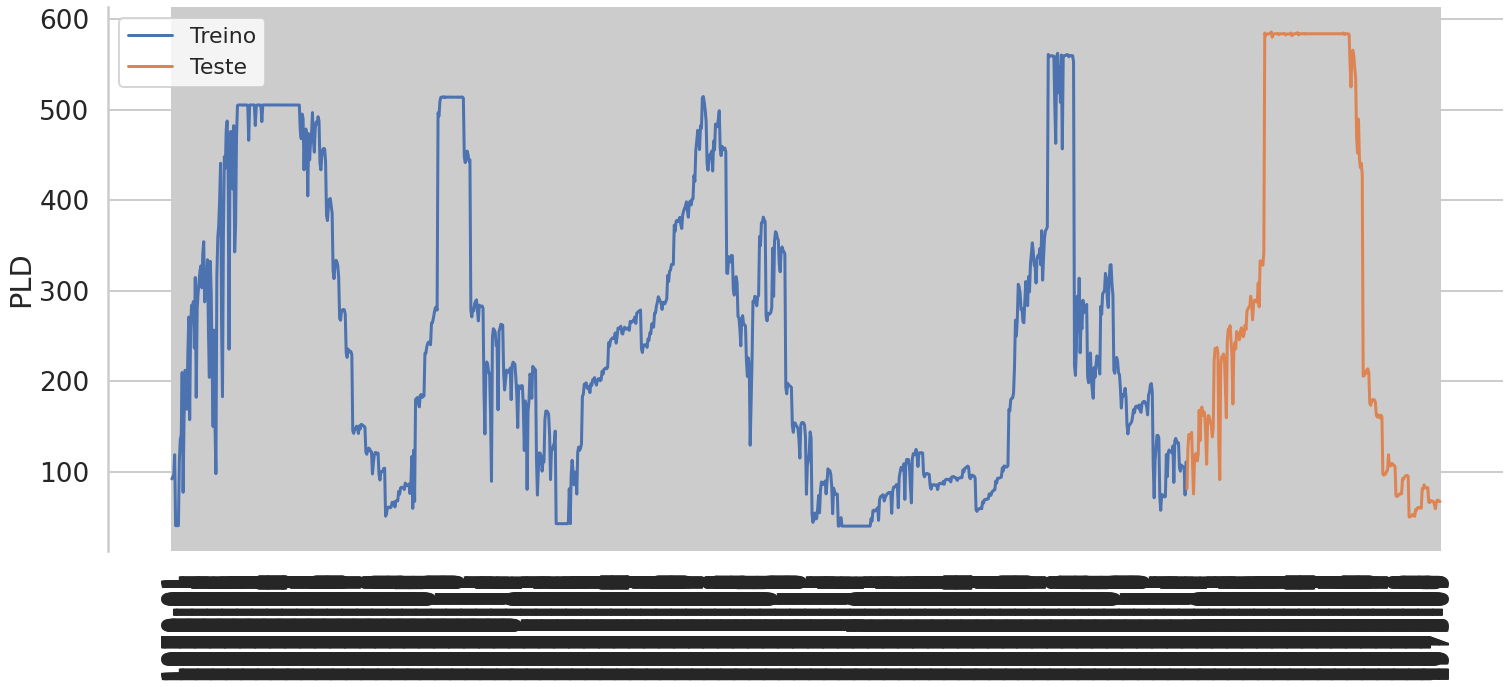

In [34]:
# create the time series plot

from matplotlib.dates import DateFormatter


# plotando
f, ax = plt.subplots(figsize=(25,10))
plt.style.use('seaborn-notebook')
sns.set_context('poster',font_scale=1)
sns.set_color_codes("pastel")

sns.lineplot(data=y_train, label='Treino')
sns.lineplot(data=y_test, label='Teste')


sns.despine(left=False, bottom=True)


# Define the date format
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend()
plt.ylabel("PLD")
plt.xlabel(None)
plt.xticks(rotation = 90)
plt.show();

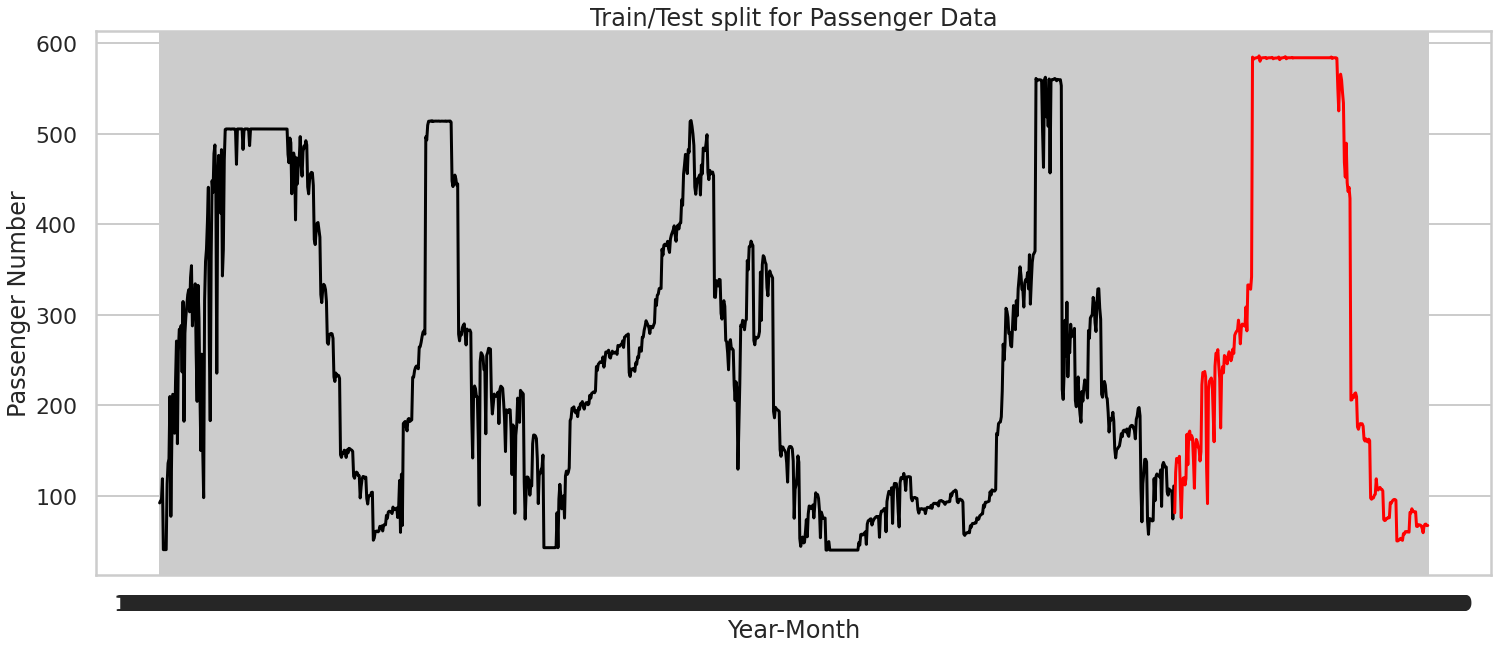

In [35]:
f, ax = plt.subplots(figsize=(25,10))

plt.plot(y_train, color = 'black')
plt.plot(y_test, color = 'red')

plt.title('Train/Test split for Passenger Data')
plt.ylabel('Passenger Number')
plt.xlabel('Year-Month')


# Define the date format
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)


sns.set()
plt.show()

<AxesSubplot:xlabel='pld_medio'>

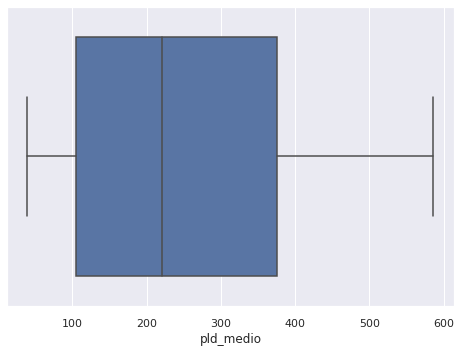

In [36]:
sns.boxplot(_sudeste['pld_medio'])

<AxesSubplot:xlabel='carga_mwmed'>

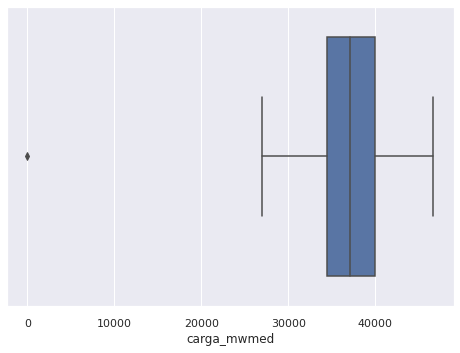

In [37]:
sns.boxplot(_sudeste['carga_mwmed'])